# ECE 661 Final

ResNet56 on White-box attacks and Black-box attacks;

Transferability Tested on ViT-32

In [1]:
# conenct to google drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ECE Final

Mounted at /content/drive
/content/drive/MyDrive/ECE Final


Preparing Environment

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from ResNetPytorch import resnet56
from AttackWrappersWhiteBoxP import FGSMNativePytorch, MIMNativePytorch
import matplotlib.pyplot as plt
import torchvision

Loading ResNet56

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet56(inputImageSize=32, numClasses=10).to(device)

In [5]:
# Data preprocessing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Data augmentation
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to [-1, 1]
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Data preprocessing for 224x224 inputs
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

## Pretraining

In [8]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [7]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / total
    return epoch_loss, accuracy

In [9]:
def validate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(test_loader)
    accuracy = 100. * correct / total
    return epoch_loss, accuracy

In [52]:
num_epochs = 20

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, test_loader, criterion, device)
    scheduler.step()  # Update learning rate

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

/content/drive/MyDrive/ECE Final/ResNetPytorch.py:161: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(self.sm(out))


Epoch 1/20, Train Loss: 2.2412, Train Acc: 19.77%, Val Loss: 2.1882, Val Acc: 25.99%
Epoch 2/20, Train Loss: 2.1348, Train Acc: 32.70%, Val Loss: 2.0843, Val Acc: 37.84%
Epoch 3/20, Train Loss: 2.0657, Train Acc: 39.56%, Val Loss: 2.0202, Val Acc: 44.34%
Epoch 4/20, Train Loss: 2.0194, Train Acc: 44.17%, Val Loss: 2.0281, Val Acc: 42.91%
Epoch 5/20, Train Loss: 1.9761, Train Acc: 48.82%, Val Loss: 1.9681, Val Acc: 49.32%
Epoch 6/20, Train Loss: 1.9392, Train Acc: 52.59%, Val Loss: 1.9280, Val Acc: 53.47%
Epoch 7/20, Train Loss: 1.9048, Train Acc: 56.03%, Val Loss: 1.8923, Val Acc: 56.70%
Epoch 8/20, Train Loss: 1.8748, Train Acc: 59.03%, Val Loss: 1.8737, Val Acc: 58.83%
Epoch 9/20, Train Loss: 1.8471, Train Acc: 62.07%, Val Loss: 1.8218, Val Acc: 64.15%
Epoch 10/20, Train Loss: 1.8252, Train Acc: 64.16%, Val Loss: 1.8224, Val Acc: 64.27%
Epoch 11/20, Train Loss: 1.8046, Train Acc: 66.12%, Val Loss: 1.7992, Val Acc: 66.18%
Epoch 12/20, Train Loss: 1.7834, Train Acc: 68.41%, Val Loss: 1

In [53]:
torch.save(model.state_dict(), "resnet56_cifar10_2.pth")
print("Model saved as resnet56_cifar10.pth")

Model saved as resnet56_cifar10.pth


## Loading Model from saved

In [10]:
model.load_state_dict(torch.load("resnet56_cifar10_2.pth"))
model.eval()

test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

<ipython-input-10-a271931a23ba>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("resnet56_cifar10_2.pth"))
/content/drive/MyDrive/ECE Final

Test Loss: 1.6941, Test Accuracy: 77.25%


## Evaluate

In [11]:
def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    return accuracy

In [12]:
# Clean Accuracy
clean_accuracy = evaluate(model, test_loader)
print(f"Accuracy on clean test images: {clean_accuracy:.2f}%")

Accuracy: 77.25%
Accuracy on clean test images: 77.25%


## Adversarial Attacks

In [13]:
model = resnet56(inputImageSize=32, numClasses=10).to(device)
model.load_state_dict(torch.load("resnet56_cifar10_2.pth"))
model.eval()

<ipython-input-13-ae9f0afdf0ac>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("resnet56_cifar10_2.pth"))


ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (shortcut): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): BasicBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      

In [20]:
# FGSM
epsilon = 0.031  # Perturbation magnitude
clip_min = 0.0  # Minimum pixel value
clip_max = 1.0  # Maximum pixel value
targeted = False  # False for untargeted attacks, True for targeted attacks

# Generate adversarial examples using FGSMNativePytorch
adv_loader_FGSM = FGSMNativePytorch(
    device=device,
    dataLoader=test_loader,
    model=model,
    epsilonMax=epsilon,
    clipMin=clip_min,
    clipMax=clip_max,
    targeted=targeted
)

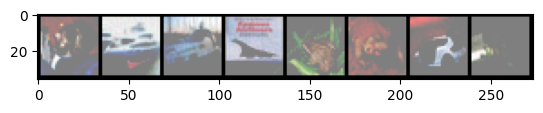

In [16]:
# Get a batch of adversarial examples
for adv_images, labels in adv_loader_FGSM:
    break

# Unnormalize for visualization
adv_images = adv_images * 0.5 + 0.5  # Assuming CIFAR-10 normalization

# Show the images
grid = torchvision.utils.make_grid(adv_images[:8])
plt.imshow(grid.permute(1, 2, 0))
plt.show()

In [76]:
# MIM
# Define parameters
epsilon = 0.031  # Maximum perturbation magnitude
epsilon_step = 0.00155  # Step size for each iteration
num_steps = 10  # Number of attack iterations
decay_factor = 1.0  # Momentum decay factor
clip_min = 0.0  # Minimum pixel value
clip_max = 1.0  # Maximum pixel value
targeted = False  # False for untargeted attacks, True for targeted attacks

# Generate adversarial examples using MIMNativePytorch
adv_loader_MIM = MIMNativePytorch(
    device=device,
    dataLoader=test_loader,
    model=model,
    decayFactor=decay_factor,
    epsilonMax=epsilon,
    epsilonStep=epsilon_step,
    numSteps=num_steps,
    clipMin=clip_min,
    clipMax=clip_max,
    targeted=targeted
)

Processing up to sample= 64
Processing up to sample= 128
Processing up to sample= 192
Processing up to sample= 256
Processing up to sample= 320
Processing up to sample= 384
Processing up to sample= 448
Processing up to sample= 512
Processing up to sample= 576
Processing up to sample= 640
Processing up to sample= 704
Processing up to sample= 768
Processing up to sample= 832
Processing up to sample= 896
Processing up to sample= 960
Processing up to sample= 1024
Processing up to sample= 1088
Processing up to sample= 1152
Processing up to sample= 1216
Processing up to sample= 1280
Processing up to sample= 1344
Processing up to sample= 1408
Processing up to sample= 1472
Processing up to sample= 1536
Processing up to sample= 1600
Processing up to sample= 1664
Processing up to sample= 1728
Processing up to sample= 1792
Processing up to sample= 1856
Processing up to sample= 1920
Processing up to sample= 1984
Processing up to sample= 2048
Processing up to sample= 2112
Processing up to sample= 2

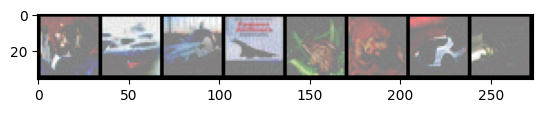

In [19]:
# Get a batch of adversarial examples
for adv_images, labels in adv_loader_MIM:
    break

# Unnormalize for visualization (assuming CIFAR-10 normalization)
adv_images = adv_images * 0.5 + 0.5  # If normalized to [-1, 1], reverse to [0, 1]

# Plot the images
grid = torchvision.utils.make_grid(adv_images[:8])
plt.imshow(grid.permute(1, 2, 0))
plt.show()

In [77]:
def PGDNativePytorch(device, dataLoader, model, epsilonMax, epsilonStep, numSteps, clipMin, clipMax, targeted):
    model.eval()
    numSamples = len(dataLoader.dataset)
    xShape = next(iter(dataLoader))[0].shape[1:]
    xAdv = torch.zeros(numSamples, *xShape)
    yClean = torch.zeros(numSamples, dtype=torch.long)

    advSampleIndex = 0
    for xData, yData in dataLoader:
        xData, yData = xData.to(device), yData.to(device)
        batchSize = xData.shape[0]
        advImages = xData.clone().detach()

        # PGD iterations
        for _ in range(numSteps):
            advImages.requires_grad = True
            outputs = model(advImages)
            loss = torch.nn.CrossEntropyLoss()(outputs, yData)
            model.zero_grad()
            loss.backward()

            # Generate adversarial perturbations
            gradSign = advImages.grad.sign()
            if targeted:
                advImages = advImages - epsilonStep * gradSign  # Targeted: decrease towards target
            else:
                advImages = advImages + epsilonStep * gradSign  # Untargeted: increase loss

            # Project adversarial examples to epsilon-ball and clip to valid range
            advImages = torch.clamp(advImages, xData - epsilonMax, xData + epsilonMax)
            advImages = torch.clamp(advImages, clipMin, clipMax).detach()

        # Save adversarial examples
        for j in range(batchSize):
            xAdv[advSampleIndex] = advImages[j].cpu()
            yClean[advSampleIndex] = yData[j].cpu()
            advSampleIndex += 1

    # Return DataLoader with adversarial examples
    advLoader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(xAdv, yClean),
        batch_size=dataLoader.batch_size,
        shuffle=False
    )
    return advLoader

In [78]:
# Define PGD parameters
epsilon = 0.031  # Maximum perturbation magnitude
epsilon_step = 0.00155  # Step size
num_steps = 20  # Number of attack iterations
clip_min = 0.0  # Minimum pixel value
clip_max = 1.0  # Maximum pixel value
targeted = False  # False for untargeted attacks, True for targeted attacks

# Generate adversarial examples using PGD
adv_loader_PGD = PGDNativePytorch(
    device=device,
    dataLoader=test_loader,
    model=model,
    epsilonMax=epsilon,
    epsilonStep=epsilon_step,
    numSteps=num_steps,
    clipMin=clip_min,
    clipMax=clip_max,
    targeted=targeted
)

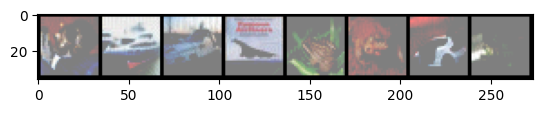

In [64]:
for adv_images, labels in adv_loader_PGD:
    break

# Unnormalize for visualization
adv_images = adv_images * 0.5 + 0.5
# Show the images
grid = torchvision.utils.make_grid(adv_images[:8])
plt.imshow(grid.permute(1, 2, 0))
plt.show()

In [35]:
!pip install torchattacks

In [79]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchattacks import APGD

def APGDNativePytorch(
    device, dataLoader, model, epsilonMax, numSteps, clipMin, clipMax, restarts=1, rho=0.75, max_queries=5000
):
    """
    Implements the APGD attack with parameters specified in the paper.

    Args:
        device (torch.device): Device for computations.
        dataLoader (DataLoader): DataLoader for clean test images.
        model (nn.Module): Target model.
        epsilonMax (float): Maximum perturbation magnitude.
        numSteps (int): Number of attack iterations.
        clipMin (float): Minimum pixel value.
        clipMax (float): Maximum pixel value.
        restarts (int): Number of restarts (default: 1).
        rho (float): Early stopping threshold (default: 0.75).
        max_queries (int): Maximum number of queries per sample (default: 5000).

    Returns:
        DataLoader: DataLoader containing adversarial examples and their true labels.
    """
    model.eval()
    attack = APGD(model, eps=epsilonMax, steps=numSteps, n_restarts=restarts)

    # Store adversarial examples
    numSamples = len(dataLoader.dataset)
    xShape = next(iter(dataLoader))[0].shape[1:]
    xAdv = torch.zeros(numSamples, *xShape)
    yClean = torch.zeros(numSamples, dtype=torch.long)

    advSampleIndex = 0
    query_count = 0

    for xData, yData in dataLoader:
        xData, yData = xData.to(device), yData.to(device)

        # Early stopping mechanism based on ρ and max_queries
        for restart in range(restarts):
            if query_count >= max_queries:
                break  # Stop if query budget is reached

            advImages = attack(xData, yData)

            # Update query count
            query_count += xData.size(0)

            # Check if early stopping conditions (ρ) are satisfied
            outputs = model(advImages)
            _, preds = outputs.max(1)
            success_rate = ((preds != yData).sum().item()) / yData.size(0)

            if success_rate >= rho:
                break  # Early stopping if success rate reaches threshold

        # Save adversarial examples
        batchSize = xData.shape[0]
        for j in range(batchSize):
            xAdv[advSampleIndex] = advImages[j].cpu()
            yClean[advSampleIndex] = yData[j].cpu()
            advSampleIndex += 1

    # Return DataLoader with adversarial examples
    advLoader = DataLoader(
        TensorDataset(xAdv, yClean),
        batch_size=dataLoader.batch_size,
        shuffle=False
    )
    return advLoader

In [80]:
# Parameters for APGD from the paper
epsilon = 0.031
num_steps = 50
restarts = 1
rho = 0.75
max_queries = 5000
clip_min = 0.0
clip_max = 1.0

# Generate adversarial examples using APGD
adv_loader_APGD = APGDNativePytorch(
    device=device,
    dataLoader=test_loader,
    model=model,
    epsilonMax=epsilon,
    numSteps=num_steps,
    clipMin=clip_min,
    clipMax=clip_max,
    restarts=restarts,
    rho=rho,
    max_queries=max_queries
)

Accuracy: 5.09%


5.09

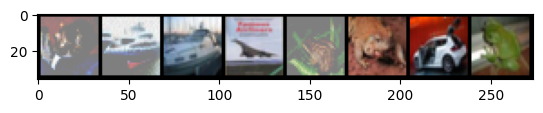

In [68]:
for adv_images, labels in adv_loader_APGD:
    break

# Unnormalize for visualization
adv_images = adv_images * 0.5 + 0.5

# Show the images
grid = torchvision.utils.make_grid(adv_images[:8])
plt.imshow(grid.permute(1, 2, 0))
plt.show()

In [81]:
evaluate(model, adv_loader_FGSM)

Accuracy: 18.57%


18.57

In [82]:
evaluate(model, adv_loader_MIM)

Accuracy: 5.89%


5.89

In [85]:
evaluate(model, adv_loader_PGD)

Accuracy: 2.57%


2.57

In [84]:
evaluate(model, adv_loader_APGD)

Accuracy: 5.09%


5.09

Additional White-box Attacks

In [101]:
def BPDANativePytorch(device, dataLoader, model, epsilonMax, epsilonStep, numSteps, clipMin, clipMax):
    model.eval()  # Set the model to evaluation mode

    # Initialize variables to store adversarial examples
    numSamples = len(dataLoader.dataset)
    xShape = next(iter(dataLoader))[0].shape[1:]  # Get the input shape from DataLoader
    xAdv = torch.zeros(numSamples, *xShape)
    yClean = torch.zeros(numSamples, dtype=torch.long)
    advSampleIndex = 0

    for xData, yData in dataLoader:
        xData, yData = xData.to(device), yData.to(device)
        batchSize = xData.size(0)
        advImages = xData.clone().detach()

        # BPDA iterations
        for _ in range(numSteps):
            advImages.requires_grad = True

            # Forward pass through the model (with a differentiable approximation if needed)
            outputs = model(advImages)

            # Define a loss function (e.g., CrossEntropyLoss)
            loss = torch.nn.CrossEntropyLoss()(outputs, yData)

            # Zero all gradients, compute gradients, and update adversarial examples
            model.zero_grad()
            loss.backward()

            # Approximate gradients of non-differentiable operations here if applicable
            gradSign = advImages.grad.sign()
            advImages = advImages + epsilonStep * gradSign
            advImages = torch.clamp(advImages, xData - epsilonMax, xData + epsilonMax)  # Epsilon-ball projection
            advImages = torch.clamp(advImages, clipMin, clipMax).detach()  # Clip to valid range

        # Save adversarial examples
        for j in range(batchSize):
            xAdv[advSampleIndex] = advImages[j].cpu()
            yClean[advSampleIndex] = yData[j].cpu()
            advSampleIndex += 1

    # Return a DataLoader with adversarial examples
    advLoader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(xAdv, yClean),
        batch_size=dataLoader.batch_size,
        shuffle=False
    )
    return advLoader

In [102]:
# BPDA parameters
epsilon = 0.05  # Maximum perturbation magnitude
epsilon_step = 0.01  # Step size
num_steps = 10  # Number of iterations
clip_min = 0.0
clip_max = 1.0

# Generate BPDA adversarial examples
adv_loader_BPDA = BPDANativePytorch(
    device=device,
    dataLoader=test_loader,
    model=model,
    epsilonMax=epsilon,
    epsilonStep=epsilon_step,
    numSteps=num_steps,
    clipMin=clip_min,
    clipMax=clip_max
)

/content/drive/MyDrive/ECE Final/ResNetPytorch.py:161: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(self.sm(out))


In [103]:
evaluate(model, adv_loader_BPDA)

/content/drive/MyDrive/ECE Final/ResNetPytorch.py:161: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(self.sm(out))


Accuracy: 0.44%


0.44

In [87]:
import torch.optim as optim

def CWPytorch(device, dataLoader, model, c=1.0, kappa=0, numSteps=1000, lr=0.01, clipMin=0.0, clipMax=1.0):
    model.eval()  # Set the model to evaluation mode

    # Initialize variables to store adversarial examples
    numSamples = len(dataLoader.dataset)
    xShape = next(iter(dataLoader))[0].shape[1:]  # Get input shape from DataLoader
    xAdv = torch.zeros(numSamples, *xShape)
    yClean = torch.zeros(numSamples, dtype=torch.long)
    advSampleIndex = 0

    for xData, yData in dataLoader:
        xData, yData = xData.to(device), yData.to(device)
        batchSize = xData.size(0)

        # Initialize adversarial perturbation
        delta = torch.zeros_like(xData, requires_grad=True).to(device)

        # Define optimizer for delta
        optimizer = optim.Adam([delta], lr=lr)

        for _ in range(numSteps):
            advImages = torch.clamp(xData + delta, clipMin, clipMax)  # Add perturbation and clip to valid range

            # Forward pass
            outputs = model(advImages)

            # Define C&W loss function
            real = outputs.gather(1, yData.view(-1, 1)).squeeze()  # Correct class scores
            other = torch.max((outputs - torch.eye(outputs.size(1))[yData].to(device) * 1e4), dim=1)[0]  # Max of incorrect class scores
            f = torch.clamp(real - other + kappa, min=0)  # Confidence margin

            l2_norm = torch.sum(delta ** 2)
            loss = l2_norm + c * torch.sum(f)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Save adversarial examples
        for j in range(batchSize):
            xAdv[advSampleIndex] = torch.clamp(xData[j] + delta[j], clipMin, clipMax).cpu()
            yClean[advSampleIndex] = yData[j].cpu()
            advSampleIndex += 1

    # Return a DataLoader with adversarial examples
    advLoader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(xAdv, yClean),
        batch_size=dataLoader.batch_size,
        shuffle=False
    )
    return advLoader

In [89]:
def BPDANativePytorch(device, dataLoader, model, epsilonMax, numSteps, clipMin, clipMax, lr=0.5, max_iters=100):
    """
    Implements BPDA with parameters specified in the paper.

    Args:
        device (torch.device): Device for computations.
        dataLoader (DataLoader): DataLoader for clean test examples.
        model (nn.Module): Target model.
        epsilonMax (float): Maximum perturbation magnitude.
        numSteps (int): Number of attack iterations (steps per max_iter cycle).
        clipMin (float): Minimum pixel value.
        clipMax (float): Maximum pixel value.
        lr (float): Learning rate for perturbation updates.
        max_iters (int): Maximum number of total iterations.

    Returns:
        DataLoader: DataLoader containing adversarial examples and their true labels.
    """
    model.eval()  # Set the model to evaluation mode

    # Initialize variables to store adversarial examples
    numSamples = len(dataLoader.dataset)
    xShape = next(iter(dataLoader))[0].shape[1:]  # Get the input shape from DataLoader
    xAdv = torch.zeros(numSamples, *xShape)
    yClean = torch.zeros(numSamples, dtype=torch.long)
    advSampleIndex = 0

    for xData, yData in dataLoader:
        xData, yData = xData.to(device), yData.to(device)
        batchSize = xData.size(0)
        advImages = xData.clone().detach()

        # Initialize total iteration count
        total_iters = 0

        # BPDA iterations with max_iters limit
        while total_iters < max_iters:
            advImages.requires_grad = True

            # Forward pass through the model
            outputs = model(advImages)

            # Define a loss function (e.g., CrossEntropyLoss)
            loss = torch.nn.CrossEntropyLoss()(outputs, yData)

            # Zero all gradients, compute gradients, and update adversarial examples
            model.zero_grad()
            loss.backward()

            # Approximate gradients of non-differentiable operations (if applicable)
            gradSign = advImages.grad.sign()

            # Update adversarial examples with learning rate
            advImages = advImages + lr * gradSign
            advImages = torch.clamp(advImages, xData - epsilonMax, xData + epsilonMax)  # Epsilon-ball projection
            advImages = torch.clamp(advImages, clipMin, clipMax).detach()  # Clip to valid range

            # Increment total iterations
            total_iters += numSteps

        # Save adversarial examples
        for j in range(batchSize):
            xAdv[advSampleIndex] = advImages[j].cpu()
            yClean[advSampleIndex] = yData[j].cpu()
            advSampleIndex += 1

    # Return a DataLoader with adversarial examples
    advLoader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(xAdv, yClean),
        batch_size=dataLoader.batch_size,
        shuffle=False
    )
    return advLoader

In [91]:
# Parameters for BPDA from the paper
epsilon = 0.031
num_steps = 100  # Steps per iteration
max_iters = 100  # Total iterations
learning_rate = 0.5
clip_min = 0.0
clip_max = 1.0

# Generate adversarial examples using BPDA
adv_loader_BPDA = BPDANativePytorch(
    device=device,
    dataLoader=test_loader,
    model=model,
    epsilonMax=epsilon,
    numSteps=num_steps,
    clipMin=clip_min,
    clipMax=clip_max,
    lr=learning_rate,
    max_iters=max_iters
)

In [92]:
evaluate(model, adv_loader_BPDA)

Accuracy: 18.57%


18.57

In [88]:
def CWPytorch(device, dataLoader, model, c=1.0, kappa=0, numSteps=1000, lr=0.01, clipMin=0.0, clipMax=1.0):
    model.eval()  # Set the model to evaluation mode

    # Initialize variables to store adversarial examples
    numSamples = len(dataLoader.dataset)
    xShape = next(iter(dataLoader))[0].shape[1:]  # Get input shape from DataLoader
    xAdv = torch.zeros(numSamples, *xShape)
    yClean = torch.zeros(numSamples, dtype=torch.long)
    advSampleIndex = 0

    for xData, yData in dataLoader:
        xData, yData = xData.to(device), yData.to(device)
        batchSize = xData.size(0)

        # Initialize adversarial perturbation
        delta = torch.zeros_like(xData, requires_grad=True).to(device)

        # Define optimizer for delta
        optimizer = optim.Adam([delta], lr=lr)

        for _ in range(numSteps):
            advImages = torch.clamp(xData + delta, clipMin, clipMax)  # Add perturbation and clip to valid range

            # Forward pass
            outputs = model(advImages)

            # Define C&W loss function
            real = outputs.gather(1, yData.view(-1, 1)).squeeze()  # Correct class scores
            one_hot = torch.eye(outputs.size(1), device=device)[yData]
            other = torch.max((outputs - one_hot * 1e4), dim=1)[0]  # Max of incorrect class scores
            f = torch.clamp(real - other + kappa, min=0)  # Confidence margin

            l2_norm = torch.sum(delta ** 2)
            loss = l2_norm + c * torch.sum(f)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Save adversarial examples
        for j in range(batchSize):
            xAdv[advSampleIndex] = torch.clamp(xData[j] + delta[j], clipMin, clipMax).cpu()
            yClean[advSampleIndex] = yData[j].cpu()
            advSampleIndex += 1

    # Return a DataLoader with adversarial examples
    advLoader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(xAdv, yClean),
        batch_size=dataLoader.batch_size,
        shuffle=False
    )
    return advLoader

In [90]:
# C&W parameters
c = 1.0  # Regularization constant
kappa = 0  # Confidence margin
num_steps = 100  # Number of iterations
lr = 0.01  # Learning rate
clip_min = 0.0
clip_max = 1.0

# Generate C&W adversarial examples
adv_loader_CW = CWPytorch(
    device=device,
    dataLoader=test_loader,
    model=model,
    c=c,
    kappa=kappa,
    numSteps=num_steps,
    lr=lr,
    clipMin=clip_min,
    clipMax=clip_max
)

/content/drive/MyDrive/ECE Final/ResNetPytorch.py:161: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(self.sm(out))


In [91]:
evaluate(model, adv_loader_CW)

Accuracy on adversarial examples: 9.53%


9.53

## Black-box attacks

In [37]:
import torch

def RaySAttack(model, images, labels, epsilon=0.031, query_budget=10000, device='cuda'):
    """
    Implements the RayS attack with parameters aligned to the paper.

    Args:
        model (nn.Module): The target model.
        images (torch.Tensor): Input images (batch).
        labels (torch.Tensor): True labels for the images.
        epsilon (float): Maximum perturbation (l∞ norm).
        query_budget (int): Maximum number of queries per sample.
        device (torch.device): Device for computations.

    Returns:
        torch.Tensor: Adversarial examples.
    """
    model.eval()  # Ensure the model is in evaluation mode

    # Initialize perturbations
    batch_size = images.size(0)
    perturbations = torch.zeros_like(images, device=device)
    step_size = epsilon / query_budget

    # Iteratively refine adversarial examples
    for query_count in range(query_budget):
        with torch.no_grad():
            # Generate random directions for the perturbation
            directions = torch.randn_like(images).sign().to(device)

            # Try adding and subtracting perturbations along the direction
            pos_images = torch.clamp(images + perturbations + step_size * directions, 0, 1)
            neg_images = torch.clamp(images + perturbations - step_size * directions, 0, 1)

            # Query the model for predictions
            pos_outputs = model(pos_images)
            neg_outputs = model(neg_images)

            # Identify misclassified samples
            _, pos_preds = pos_outputs.max(1)
            _, neg_preds = neg_outputs.max(1)

            pos_misclassified = pos_preds != labels
            neg_misclassified = neg_preds != labels

            # Update perturbations
            perturbations[pos_misclassified] += step_size * directions[pos_misclassified]
            perturbations[neg_misclassified] -= step_size * directions[neg_misclassified]

            # Stop early if all examples are misclassified
            if pos_misclassified.sum().item() + neg_misclassified.sum().item() == batch_size:
                break

    # Apply final perturbations
    adversarial_examples = torch.clamp(images + perturbations, 0, 1)
    return adversarial_examples

In [40]:
# Generate adversarial examples for a batch of data
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    adv_images = RaySAttack(model, images, labels, epsilon=0.031, query_budget=10000, device=device)
    break

# Evaluate the target model on these adversarial examples
adv_loader_RayS = DataLoader(torch.utils.data.TensorDataset(adv_images, labels), batch_size=64)
evaluate(model, adv_loader_RayS)

Accuracy: 43.75%


43.75

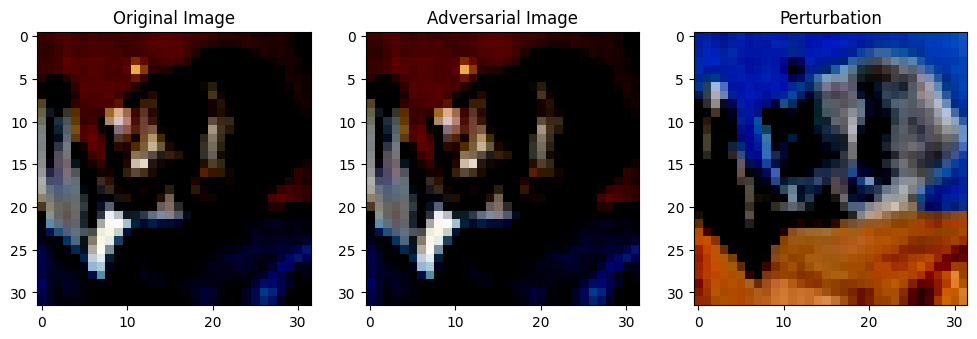

In [41]:
original = images.cpu().detach().numpy()
adversarial = adv_images.cpu().detach().numpy()
perturbation = adversarial - original

# Plot original, adversarial, and perturbation
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(np.transpose(original[0], (1, 2, 0)))
axes[0].set_title("Original Image")
axes[1].imshow(np.transpose(adversarial[0], (1, 2, 0)))
axes[1].set_title("Adversarial Image")
axes[2].imshow(np.transpose(perturbation[0], (1, 2, 0)))
axes[2].set_title("Perturbation")
plt.show()

In [45]:
import torch
from torch.utils.data import DataLoader, TensorDataset

def generate_rays_adv_loader(model, data_loader, epsilon, query_budget, device):
    """
    Generate adversarial examples using the RayS attack for the entire dataset.

    Args:
        model (nn.Module): The target model.
        data_loader (DataLoader): DataLoader containing clean test examples.
        epsilon (float): Maximum perturbation magnitude (l∞ norm).
        query_budget (int): Maximum number of queries per sample.
        device (torch.device): Device to run computations on.

    Returns:
        DataLoader: DataLoader containing adversarial examples and their true labels.
    """
    model.eval()

    adv_images_list = []
    labels_list = []

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

        # Generate adversarial examples for the batch
        adv_images = RaySAttack(model, images, labels, epsilon, query_budget, device)  # Remove 'epsilon_max' argument

        # Append adversarial examples and labels to the list
        adv_images_list.append(adv_images.cpu())
        labels_list.append(labels.cpu())

    # Concatenate all adversarial examples and labels
    adv_images_all = torch.cat(adv_images_list, dim=0)
    labels_all = torch.cat(labels_list, dim=0)

    # Create a new DataLoader for adversarial examples
    adv_dataset = TensorDataset(adv_images_all, labels_all)
    adv_loader = DataLoader(adv_dataset, batch_size=data_loader.batch_size, shuffle=False)

    return adv_loader

In [ ]:
import torch
from torch.utils.data import Subset
import numpy as np

def create_subset(dataset, subset_percentage, seed=None):
    """
    Create a subset of a dataset based on a specified percentage.

    Args:
        dataset (torch.utils.data.Dataset): The full dataset.
        subset_percentage (float): The percentage of the dataset to use (e.g., 0.1 for 10%).
        seed (int, optional): Seed for reproducibility. Default is None.

    Returns:
        Subset: A subset of the dataset.
    """
    if seed is not None:
        np.random.seed(seed)  # Set the seed for reproducibility

    total_samples = len(dataset)
    subset_size = int(total_samples * subset_percentage)

    # Generate random indices for the subset
    subset_indices = np.random.choice(range(total_samples), subset_size, replace=False)

    # Create a subset dataset
    return Subset(dataset, subset_indices)

In [51]:
subset_indices = np.random.choice(len(test_dataset), size=1000, replace=False)
test_subset = Subset(test_dataset, subset_indices)
test_loader_subset = DataLoader(test_subset, batch_size=64, shuffle=False, num_workers=2)

In [53]:
# Parameters for RayS attack
epsilon = 0.031
query_budget = 1000

# Generate adversarial examples for the entire test dataset
adv_loader_RayS = generate_rays_adv_loader(model=model, data_loader=test_loader_subset, epsilon=epsilon, query_budget=query_budget, device=device)

# Evaluate the target model on these adversarial examples
evaluate(model, adv_loader_RayS)

Accuracy: 35.60%


35.6

In [57]:
def RaySAttack(model, images, labels, epsilon, query_budget, device):
    model.eval()  # Ensure the model is in evaluation mode

    batch_size = images.size(0)
    perturbations = torch.zeros_like(images, device=device)

    # Initial random directions
    directions = torch.randn_like(images).sign().to(device)

    for query_count in range(query_budget):
        # Positive and negative perturbations
        pos_images = torch.clamp(images + perturbations + epsilon * directions, 0, 1)
        neg_images = torch.clamp(images + perturbations - epsilon * directions, 0, 1)

        # Query the model
        pos_outputs = model(pos_images)
        neg_outputs = model(neg_images)

        # Get predictions
        _, pos_preds = pos_outputs.max(1)
        _, neg_preds = neg_outputs.max(1)

        # Update perturbations based on misclassification
        pos_misclassified = pos_preds != labels
        neg_misclassified = neg_preds != labels

        perturbations[pos_misclassified] += epsilon * directions[pos_misclassified]
        perturbations[neg_misclassified] -= epsilon * directions[neg_misclassified]

        # Stop if all images are misclassified
        if pos_misclassified.sum() + neg_misclassified.sum() == batch_size:
            break

    # Apply the final perturbations
    adversarial_examples = torch.clamp(images + perturbations, 0, 1)
    return adversarial_examples

In [58]:
def generate_rays_adv_loader(model, data_loader, epsilon, query_budget, device):
    model.eval()

    adv_images_list = []
    labels_list = []

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

        batch_adv_images = []
        for i in range(images.size(0)):
            # Run RaySAttack on a single image
            adv_image = RaySAttack(
                model=model,
                images=images[i:i+1],  # Single image
                labels=labels[i:i+1],
                epsilon=epsilon,
                query_budget=query_budget,
                device=device
            )
            batch_adv_images.append(adv_image)

        # Concatenate adversarial examples for the batch
        adv_images_list.append(torch.cat(batch_adv_images, dim=0).cpu())
        labels_list.append(labels.cpu())

    # Concatenate all adversarial examples and labels
    adv_images_all = torch.cat(adv_images_list, dim=0)
    labels_all = torch.cat(labels_list, dim=0)

    # Create a new DataLoader for adversarial examples
    adv_dataset = TensorDataset(adv_images_all, labels_all)
    adv_loader = DataLoader(adv_dataset, batch_size=data_loader.batch_size, shuffle=False)

    return adv_loader

In [67]:
subset_indices = np.random.choice(len(test_dataset), size=100, replace=False)
test_subset = Subset(test_dataset, subset_indices)
test_loader_subset = DataLoader(test_subset, batch_size=64, shuffle=False, num_workers=2)

In [68]:
adv_loader_RayS = generate_rays_adv_loader(
    model=model,
    data_loader=test_loader_subset,
    epsilon=0.031,
    query_budget=100,
    device=device
)

In [69]:
evaluate(model, adv_loader_RayS)

Accuracy: 35.00%


35.0

## Testing Transferability

### Load ViT-32 and Resize

In [17]:
# Loading ViT-32
import torch
from timm import create_model

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the ViT model (ensure num_classes matches CIFAR-10)
vit_model = create_model('vit_base_patch32_224', pretrained=False, num_classes=10)
vit_model = vit_model.to(device)

# Load the pretrained weights for ViT
checkpoint_path = "vit_b32_cifar10.pth"  # Replace with your ViT weights path
vit_model.load_state_dict(torch.load(checkpoint_path, map_location=device))

<ipython-input-17-ba8ad6869300>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit_model.load_state_dict(torch.load(checkpoint_path, map_location=device))


<All keys matched successfully>

In [36]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Define transformations for ViT
vit_transform_train = transforms.Compose([
    transforms.Resize(224),  # Resize to 224x224 for ViT
    transforms.RandomCrop(224, padding=4),  # Optional data augmentation
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to [-1, 1]
])

vit_transform_test = transforms.Compose([
    transforms.Resize(224),  # Resize to 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to [-1, 1]
])

# Load CIFAR-10 dataset with ViT transformations
vit_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=vit_transform_train)
vit_test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=vit_transform_test)

# Create DataLoaders for ViT
vit_train_loader = DataLoader(vit_train_dataset, batch_size=64, shuffle=True, num_workers=2)
vit_test_loader = DataLoader(vit_test_dataset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [37]:
# Evaluate the ViT model on resized CIFAR-10 test data
test_loss, test_acc = validate(vit_model, vit_test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.6241, Test Accuracy: 81.18%


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import Resize

# Function to resize adversarial examples
def resize_adv_loader(adv_loader, target_size, device):
    """
    Resize adversarial examples to match the target model's input size.

    Args:
        adv_loader (DataLoader): DataLoader containing adversarial examples and labels.
        target_size (tuple): Target size (height, width) for resizing.
        device (torch.device): Device for computations.

    Returns:
        DataLoader: DataLoader with resized adversarial examples.
    """
    resized_images = []
    resized_labels = []

    for images, labels in adv_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Resize images
        resized = torch.nn.functional.interpolate(images, size=target_size, mode='bilinear', align_corners=False)
        resized_images.append(resized.cpu())
        resized_labels.append(labels.cpu())

    # Concatenate resized images and labels
    resized_images = torch.cat(resized_images)
    resized_labels = torch.cat(resized_labels)

    # Create a new DataLoader
    dataset = TensorDataset(resized_images, resized_labels)
    resized_loader = DataLoader(dataset, batch_size=adv_loader.batch_size, shuffle=False)

    return resized_loader

### Evaluate Transferability on the first four white-box attacks and RayS black-box attack

In [ ]:
# Function to evaluate transferability
def evaluate_transferability(target_model, adv_loader, device):
    """
    Evaluate transferability of adversarial examples on the target model.

    Args:
        target_model (nn.Module): The target model (e.g., ViT-B-32).
        adv_loader (DataLoader): DataLoader containing adversarial examples and their true labels.
        device (torch.device): Device for computations.

    Returns:
        float: Transferability success rate (% of adversarial examples that are misclassified).
    """
    target_model.eval()
    correct = 0
    total = 0

    for adv_images, labels in adv_loader:
        adv_images, labels = adv_images.to(device), labels.to(device)

        # Test adversarial examples on the target model
        outputs = target_model(adv_images)
        _, predicted = outputs.max(1)

        # Count correctly classified examples
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    transfer_success_rate = 100.0 * (1 - correct / total)
    print(f"Transferability Success Rate: {transfer_success_rate:.2f}%")
    return transfer_success_rate

In [70]:
adv_loader_resized = resize_adv_loader(adv_loader_FGSM, target_size=(224, 224), device=device)

Transferability Success Rate: 58.43%


In [71]:
transfer_success_rate = evaluate_transferability(
    target_model=vit_model,
    adv_loader=adv_loader_resized,
    device=device
)

Transferability Success Rate: 58.43%


In [74]:
evaluate(vit_model, adv_loader_resized)

Accuracy: 41.57%


41.57

In [93]:
# MIM
adv_loader_resized_MIM = resize_adv_loader(adv_loader_MIM, target_size=(224, 224), device=device)

In [94]:
evaluate(vit_model, adv_loader_resized_MIM)

Accuracy: 41.15%


41.15

In [96]:
transfer_success_rate_MIM = evaluate_transferability(
    target_model=vit_model,
    adv_loader=adv_loader_resized_MIM,
    device=device
)

Transferability Success Rate: 58.85%


In [97]:
# PGD
adv_loader_resized_PGD = resize_adv_loader(adv_loader_PGD, target_size=(224, 224), device=device)
evaluate(vit_model, adv_loader_resized_PGD)
transfer_success_rate_PGD = evaluate_transferability(
    target_model=vit_model,
    adv_loader=adv_loader_resized_PGD,
    device=device
)

Accuracy: 41.66%
Transferability Success Rate: 58.34%


In [98]:
# APGD
adv_loader_resized_APGD = resize_adv_loader(adv_loader_APGD, target_size=(224, 224), device=device)
evaluate(vit_model, adv_loader_resized_APGD)
transfer_success_rate_APGD = evaluate_transferability(
    target_model=vit_model,
    adv_loader=adv_loader_resized_APGD,
    device=device
)

Accuracy: 29.56%
Transferability Success Rate: 70.44%


In [99]:
# BPDA
adv_loader_resized_BPDA = resize_adv_loader(adv_loader_BPDA, target_size=(224, 224), device=device)
evaluate(vit_model, adv_loader_resized_BPDA)
transfer_success_rate_BPDA = evaluate_transferability(
    target_model=vit_model,
    adv_loader=adv_loader_resized_BPDA,
    device=device
)

Accuracy: 41.57%
Transferability Success Rate: 58.43%


In [104]:
# RayS
adv_loader_resized_RayS = resize_adv_loader(adv_loader_RayS, target_size=(224, 224), device=device)
evaluate(vit_model, adv_loader_resized_RayS)
transfer_success_rate_RayS = evaluate_transferability(
    target_model=vit_model,
    adv_loader=adv_loader_resized_RayS,
    device=device
)

Accuracy: 45.00%
Transferability Success Rate: 55.00%


## Filtered Transferability Test

Filtering out 1000 examples that are tested correctly by both models

In [114]:
import torch.nn.functional as F

def test_transferability_with_filtering(
    model1, model2, adv_loader, clean_loader, device, num_epochs=10, num_examples=1000, resize_to=(224, 224)
):
    """
    Test transferability with filtering and resizing, and return the maximum transferability rate over epochs.

    Args:
        model1 (nn.Module): Source model used to generate adversarial examples (e.g., ResNet56).
        model2 (nn.Module): Target model for transferability testing (e.g., ViT-B-32).
        adv_loader (DataLoader): DataLoader containing adversarial examples generated by model1.
        clean_loader (DataLoader): DataLoader containing clean examples for filtering.
        device (torch.device): Device for computations.
        num_epochs (int): Number of epochs to evaluate for transferability.
        num_examples (int): Number of examples to filter and use for evaluation.
        resize_to (tuple): Target size for resizing (e.g., (224, 224) for ViT).

    Returns:
        float: Maximum transferability success rate over the epochs.
    """
    def filter_correctly_classified(model1, model2, clean_loader, num_examples, device, resize_to):
        """
        Filter examples that both models classify correctly, with resizing.

        Args:
            model1 (nn.Module): First classifier (e.g., ResNet56).
            model2 (nn.Module): Second classifier (e.g., ViT).
            clean_loader (DataLoader): DataLoader for clean test images.
            num_examples (int): Number of examples to select.
            device (torch.device): Device to run computations on.
            resize_to (tuple): Target size for resizing.

        Returns:
            DataLoader: DataLoader with filtered examples.
        """
        model1.eval()
        model2.eval()

        filtered_images = []
        filtered_labels = []

        for images, labels in clean_loader:
            images, labels = images.to(device), labels.to(device)

            # Resize clean images for the target model
            resized_images = F.interpolate(images, size=resize_to, mode='bilinear', align_corners=False)

            # Predictions from both models
            outputs1 = model1(images)  # Model1 uses original image size
            outputs2 = model2(resized_images)  # Model2 uses resized images

            _, preds1 = outputs1.max(1)
            _, preds2 = outputs2.max(1)

            # Keep examples both models classify correctly
            correct_mask = (preds1 == labels) & (preds2 == labels)
            filtered_images.append(images[correct_mask])
            filtered_labels.append(labels[correct_mask])

            # Stop once we reach the desired number of examples
            if sum(len(img) for img in filtered_images) >= num_examples:
                break

        # Concatenate filtered examples
        filtered_images = torch.cat(filtered_images)[:num_examples]
        filtered_labels = torch.cat(filtered_labels)[:num_examples]

        # Create a new DataLoader
        dataset = torch.utils.data.TensorDataset(filtered_images, filtered_labels)
        filtered_loader = DataLoader(dataset, batch_size=64, shuffle=False)
        return filtered_loader

    # Filter the examples successfully classified by both models
    filtered_loader = filter_correctly_classified(model1, model2, clean_loader, num_examples, device, resize_to)

    # Evaluate transferability for multiple epochs and track maximum rate
    max_transferability = 0.0

    for epoch in range(num_epochs):
        model2.eval()
        correct = 0
        total = 0

        for adv_images, labels in adv_loader:
            adv_images, labels = adv_images.to(device), labels.to(device)

            # Resize adversarial examples for the target model
            resized_adv_images = F.interpolate(adv_images, size=resize_to, mode='bilinear', align_corners=False)

            # Test adversarial examples on the target model
            outputs = model2(resized_adv_images)
            _, predicted = outputs.max(1)

            # Count correctly classified examples
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Compute transferability success rate
        transfer_success_rate = 100.0 * (1 - correct / total)
        print(f"Epoch {epoch + 1}/{num_epochs}: Transferability Success Rate: {transfer_success_rate:.2f}%")

        # Update maximum transferability
        max_transferability = max(max_transferability, transfer_success_rate)

    print(f"Maximum Transferability Success Rate: {max_transferability:.2f}%")
    return max_transferability

In [116]:
max_transferability_rate = test_transferability_with_filtering(
    model1=model,  # Source model
    model2=vit_model,  # Target model
    adv_loader=adv_loader_FGSM,  # Adversarial examples generated by ResNet56
    clean_loader=test_loader,  # Clean test examples
    device=device,
    num_epochs=1,
    num_examples=1000,
    resize_to=(224, 224)  # Resize for ViT-B-32
)

/content/drive/MyDrive/ECE Final/ResNetPytorch.py:161: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(self.sm(out))


Epoch 1/1: Transferability Success Rate: 58.43%
Maximum Transferability Success Rate: 58.43%


In [117]:
max_transferability_rate = test_transferability_with_filtering(
    model1=model,  # Source model
    model2=vit_model,  # Target model
    adv_loader=adv_loader_MIM,  # Adversarial examples generated by ResNet56
    clean_loader=test_loader,  # Clean test examples
    device=device,
    num_epochs=1,
    num_examples=1000,
    resize_to=(224, 224)  # Resize for ViT-B-32
)

/content/drive/MyDrive/ECE Final/ResNetPytorch.py:161: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(self.sm(out))


Epoch 1/1: Transferability Success Rate: 58.85%
Maximum Transferability Success Rate: 58.85%


In [118]:
max_transferability_rate = test_transferability_with_filtering(
    model1=model,  # Source model
    model2=vit_model,  # Target model
    adv_loader=adv_loader_PGD,  # Adversarial examples generated by ResNet56
    clean_loader=test_loader,  # Clean test examples
    device=device,
    num_epochs=1,
    num_examples=1000,
    resize_to=(224, 224)  # Resize for ViT-B-32
)

/content/drive/MyDrive/ECE Final/ResNetPytorch.py:161: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(self.sm(out))


Epoch 1/1: Transferability Success Rate: 58.34%
Maximum Transferability Success Rate: 58.34%


In [119]:
max_transferability_rate = test_transferability_with_filtering(
    model1=model,  # Source model
    model2=vit_model,  # Target model
    adv_loader=adv_loader_APGD,  # Adversarial examples generated by ResNet56
    clean_loader=test_loader,  # Clean test examples
    device=device,
    num_epochs=1,
    num_examples=1000,
    resize_to=(224, 224)  # Resize for ViT-B-32
)

Epoch 1/1: Transferability Success Rate: 70.44%
Maximum Transferability Success Rate: 70.44%


In [115]:
# Test transferability with filtering and resizing
max_transferability_rate = test_transferability_with_filtering(
    model1=model,  # Source model
    model2=vit_model,  # Target model
    adv_loader=adv_loader_BPDA,  # Adversarial examples generated by ResNet56
    clean_loader=test_loader,  # Clean test examples
    device=device,
    num_epochs=10,
    num_examples=1000,
    resize_to=(224, 224)  # Resize for ViT-B-32
)

/content/drive/MyDrive/ECE Final/ResNetPytorch.py:161: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(self.sm(out))


Epoch 1/10: Transferability Success Rate: 59.41%
Epoch 2/10: Transferability Success Rate: 59.41%
Epoch 3/10: Transferability Success Rate: 59.41%
Epoch 4/10: Transferability Success Rate: 59.41%
Epoch 5/10: Transferability Success Rate: 59.41%
Epoch 6/10: Transferability Success Rate: 59.41%
Epoch 7/10: Transferability Success Rate: 59.41%
Epoch 8/10: Transferability Success Rate: 59.41%
Epoch 9/10: Transferability Success Rate: 59.41%
Epoch 10/10: Transferability Success Rate: 59.41%
Maximum Transferability Success Rate: 59.41%
